<a href="https://colab.research.google.com/github/JacksonKerr/LinearRegression/blob/main/Assignment3/Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Doc Options:

In [ ]:
fast = True         # If true, uses stored graph images from GitHub repo for speed

#### Imports:

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

#### Helper functions from labs
- extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC')
- biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None)

In [ ]:
def extract_loadings(pca, feature_names=None, pipeline_component=None, prefix='PC'):
    """
       take a PCA model and extract its loadings into a data frame for easier interrogation
    """
    if pipeline_component is not None:
        pca = pca[pipeline_component]
        
    X = pca.components_.T
    
    return pd.DataFrame(X, columns=[ f'{prefix}{i+1}' for i in range(X.shape[1]) ], index=feature_names)

In [ ]:
def biplot(X, loadings=None, pc1=0, pc2=1, y=None, labels=None):
    """
      plot two principal components of data embedded via PCA along with their feature loadings
    """
    xs = X[:, pc1]
    ys = X[:, pc2]
    
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())    
    sns.scatterplot(x=xs*scalex, y=ys*scaley, hue=y, palette='viridis')
    
    if loadings is not None:
        n = len(loadings)
        if labels is None:
            labels = loadings.index.values
        for i in range(n):
            plt.arrow(0, 0, loadings.iloc[i, pc1], loadings.iloc[i, pc2], color='#ce2227', width=0.01, head_width=0.04)
            plt.text(loadings.iloc[i, pc1]* 1.15, loadings.iloc[i, pc2] * 1.15, labels[i], color='#ce2227', ha='center', va='center')
        
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel(f'PC{pc1+1}')
    plt.ylabel(f'PC{pc2+1}')
    plt.grid()

In [ ]:
def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    """
        produce a plot from a PCA embedding that visualises the amount of 
        explained variance for each of the principal components 
    """
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()

    return total_variance # Modification, return for examination

##Gettin That Data:



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
import pandas as pd

mystery_df = pd.read_csv('https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/mystery_train.csv', index_col=0).reset_index()

mystery_y = mystery_df['y']
mystery_x = mystery_df.drop(labels=['y'], axis=1)

mystery_x, mystery_x_test, mystery_y, mystery_y_test = train_test_split(mystery_x, mystery_y, train_size=0.8, random_state=1)

In [ ]:
display(mystery_x)

1233    33.503
1056    24.930
1686    18.486
187     49.419
3840    43.622
         ...  
2895    14.342
2763    25.729
905     14.359
3980    25.497
235     14.604
Name: y, Length: 4000, dtype: float64

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
1233,74.0,1.0,0.00534,0.000031,0.00284,0.00300,0.00852,0.02349,0.197,0.00998,0.01192,0.01780,0.02995,0.011598,22.611,0.53893,0.75216,0.16630
1056,73.0,1.0,0.00339,0.000017,0.00178,0.00183,0.00533,0.02571,0.252,0.01311,0.01491,0.01858,0.03933,0.027526,24.390,0.43389,0.64541,0.20944
1686,36.0,1.0,0.00449,0.000024,0.00269,0.00232,0.00806,0.01975,0.185,0.01100,0.01184,0.01298,0.03301,0.016538,23.161,0.38308,0.62710,0.18465
187,76.0,0.0,0.00457,0.000045,0.00192,0.00208,0.00576,0.02765,0.234,0.01386,0.01550,0.02131,0.04158,0.022315,22.308,0.66041,0.54973,0.18948
3840,63.0,0.0,0.00592,0.000047,0.00287,0.00277,0.00860,0.04756,0.439,0.02627,0.03255,0.03853,0.07881,0.031256,19.093,0.60753,0.62395,0.27343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,58.0,1.0,0.00574,0.000031,0.00320,0.00259,0.00961,0.01328,0.117,0.00738,0.00786,0.00930,0.02214,0.012079,22.560,0.32850,0.64315,0.14612
2763,57.0,0.0,0.00527,0.000029,0.00292,0.00324,0.00876,0.02620,0.230,0.01465,0.01629,0.01951,0.04396,0.012843,21.320,0.40321,0.56096,0.22595
905,57.0,1.0,0.00383,0.000021,0.00191,0.00185,0.00573,0.01627,0.145,0.00915,0.00852,0.01282,0.02744,0.005163,23.788,0.45399,0.71856,0.18783
3980,68.0,0.0,0.00342,0.000026,0.00141,0.00198,0.00423,0.02709,0.243,0.01120,0.01670,0.03031,0.03360,0.006698,23.565,0.46248,0.70502,0.20442


Let's have a look at the fields.

In [ ]:
mystery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      5000 non-null   float64
 1   x2      5000 non-null   float64
 2   x3      5000 non-null   float64
 3   x4      5000 non-null   float64
 4   x5      5000 non-null   float64
 5   x6      5000 non-null   float64
 6   x7      5000 non-null   float64
 7   x8      5000 non-null   float64
 8   x9      5000 non-null   float64
 9   x10     5000 non-null   float64
 10  x11     5000 non-null   float64
 11  x12     5000 non-null   float64
 12  x13     5000 non-null   float64
 13  x14     5000 non-null   float64
 14  x15     5000 non-null   float64
 15  x16     5000 non-null   float64
 16  x17     5000 non-null   float64
 17  x18     5000 non-null   float64
 18  y       5000 non-null   float64
dtypes: float64(19)
memory usage: 742.3 KB


Looks pretty standard. No missing values. All float64 decimal numbers.

## Exploratory Data Analysis

### Pairplot

Let's look at the relationships between the variables using hue="x2" as it's the only categorical variable.

In [ ]:
import seaborn as sns
import numpy as np

if fast:
  # Get stored pairplot from GitHub repo
  from IPython.display import Image
  from IPython.core.display import HTML 
  img = Image(url= "https://raw.githubusercontent.com/JacksonKerr/LinearRegression/main/Assignment3/pairplot.png")
else:
  # Create directly
  img = sns.pairplot(mystery_df, hue="x2")
img

#### Correlations:

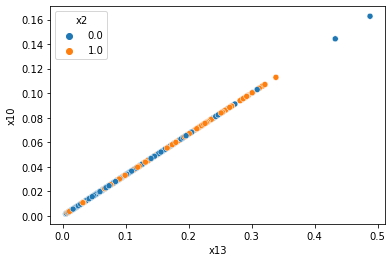

In [ ]:
sns.scatterplot(x=mystery_df["x13"], y=mystery_df["x10"], hue=mystery_df["x2"])

# Remove one
to_rem = "x13"
if to_rem in mystery_df.columns:
  mystery_df = mystery_df.drop([to_rem], axis=1)

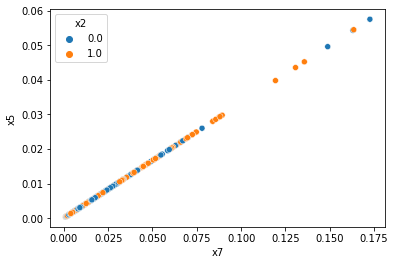

In [ ]:
sns.scatterplot(x=mystery_df["x7"], y=mystery_df["x5"], hue=mystery_df["x2"])

# Remove one
to_rem = "x7"
if to_rem in mystery_df.columns:
  mystery_df = mystery_df.drop([to_rem], axis=1)

### Heatmap

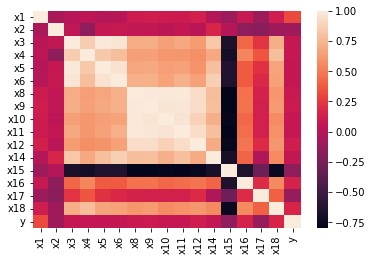

In [ ]:
sns.heatmap(mystery_df.corr())

A lot of the variables are highly correlated with eachother. This was hinted at in the pairplot earlier.

### PCA Analysis

By 10 principal components, we have already accounted for 99.006% of the variance in the data.


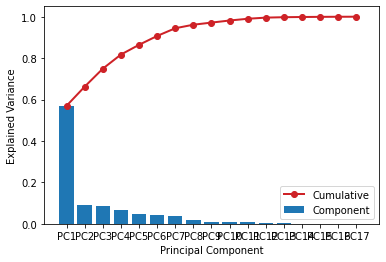

In [ ]:
def find_optimal_pca_components():
  pca = PCA()
  pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
  P = pca_pipe.fit_transform(mystery_df)

  # Draw screeplot
  pca_performance = screeplot(pca)

  # Print number of components needed to account for most of the variation
  optimal_components = None
  for i in range(len(pca_performance)):
    if pca_performance[i] > 0.99:
      optimal_components = i
      print("By", i, "principal components, we have accounted for",
            str(round(pca_performance[i]*100, 3)) + "%", "of the variance in the data.")
      break
  return optimal_components
optimal_pca_components = find_optimal_pca_components()

In [ ]:
# Apply PCA with optimal components to data
pca = PCA(optimal_pca_components)
optimal_pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])

P = optimal_pca_pipe.fit_transform(mystery_x)
mystery_x = pd.DataFrame(P)
mystery_x.columns = ["PC"+str(i+1) for i in range(len(mystery_x.columns))]
mystery_df = mystery_x.copy()
mystery_df["y"] = mystery_y

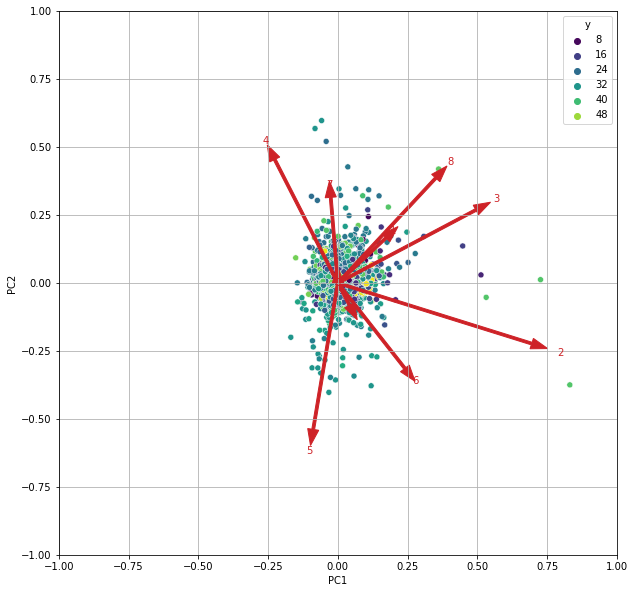

In [ ]:
# Biplot
fig = plt.figure(figsize=(10, 10))
biplot(P, extract_loadings(pca, feature_names=[str(i) for i in range(10)]), y=mystery_y)
plt.show()

## Modeling

In [ ]:
pipe = Pipeline([("scaling", "passthrough"), 
                 ("dimension_reduction", "passthrough"),
                 ("mdl", "passthrough")])

In [ ]:
scaling_options = ["passthrough"]
dim_red_options = ["passthrough"]

mdl_options = ([LinearRegression()] 
            + [MLPRegressor(n) for n in range(50, 150)] 
            + [KNeighborsRegressor(n) for n in range(1, 20)]
            + [DecisionTreeRegressor(n) for n in range(2, 30)])

tune_grids = [{'scaling': scaling_options,
               'dimension_reduction': dim_red_options,
               'mdl': mdl_options}]

rkf = RepeatedKFold(n_splits=3, n_repeats=5)

scorer = make_scorer(r2_score, greater_is_better=True)

cv = GridSearchCV(pipe, tune_grids, cv=rkf, scoring=scorer, n_jobs=-1, verbose=1).fit(mystery_x, mystery_y)

Fitting 15 folds for each of 148 candidates, totalling 2220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 2220 out of 2220 | elapsed: 47.9min finished


In [ ]:
cv.best_score_

0.9996733828966378

In [ ]:
cv.best_params_

{'dimension_reduction': 'passthrough',
 'mdl': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 'scaling': 'passthrough'}

## Hyperparameter Analysis

In [ ]:
def cross_validate_model_mse(mdl, param_grid, X, y, cv=None):
    import numpy as np
    import pandas as pd

    from sklearn.metrics import mean_squared_error, make_scorer, r2_score
    from sklearn.model_selection import GridSearchCV
    
    # create a MSE scorer
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    # perform the grid search on the supplied data
    cv = GridSearchCV(mdl, param_grid, scoring=scorer, cv=cv, n_jobs=-1)
    cv.fit(X, y)
    cv_stats = pd.DataFrame(cv.cv_results_).filter(regex='(param_.*)|(split.*_test_score)', axis=1)
    cv_stats = cv_stats.melt(id_vars=cv_stats.columns[cv_stats.columns.str.match('param_.*')], var_name='split', value_name='mse')
    cv_stats.rename(columns=lambda n: n.replace('param_', ''), inplace=True)
    cv_stats['split'] = cv_stats['split'].str.replace('split(\d+)_test_score', '\\1', regex=True).astype(np.int64)
    cv_stats['mse'] = -cv_stats['mse']
    
    return cv, cv_stats

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import RepeatedKFold

from matplotlib import pyplot as plt

rkf = RepeatedKFold(n_splits=10, n_repeats=3) # 3 ROUNDS and 10 FOLDS

target = 'medv'

# EDA Data
X = bost.drop(columns=[target]).to_numpy()
y = bost[target].to_numpy()

# ===== kNN =====
knn = KNeighborsRegressor()
knn_grid = { 'n_neighbors' : [1, 2, 5, 10, 20, 40, 80, 120, 360] }
knncv, knn_stats = cross_validate_model_mse(knn, knn_grid, X, y, cv=rkf)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
for ax in axs: ax.set_ylim((0, 1))

# Scaled virgin data
sns.lineplot(data=knn_virgin_scaled_stats, x='n_neighbors', y='mse', label='Virgin Scaled data', ax=axs[0])
sns.lineplot(data=knn_stats, x='n_neighbors', y='mse', label='EDA data', ax=axs[0])
axs[0].set_title('kNN with EDA data')